<a href="https://colab.research.google.com/github/hoeen/codestates-projects/blob/main/ai08_sc23x_%EB%B0%95%EC%9A%B0%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS SC23x 
## Applied Predictive Modeling

 이번 스프린트 챌린지에서는 시카고에 있는 식당들의 정보와 해당 식당들의 위생 검사 결과에 관한 데이터를 담은 데이터셋을 다루게 됩니다.

데이터셋에 관한 설명은 이 [PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF)를 참고해주시길 바랍니다.

#### 오늘 여러분은 Chicago시의 공중보건부가 진행한 위생 검사의 실패 여부를 예측하는 모델을 만들어야 합니다.

여러분의 모델이 예측할 target은 `Inspection Fail` 칼럼입니다.   
칼럼 값은 아래와 같습니다:
- 식당이 위생 검사에 불합격한 경우: **1**
- 식당이 검사를 통과한 경우: **0**

In [1]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [28]:
# 데이터셋을 불러오기 위해 판다스 라이브러리를 불러옵니다
import pandas as pd

train_url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_train.csv'
test_url  = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_test.csv'

# train, test 데이터셋을 불러옵니다
train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

# 데이터셋 확인
assert train.shape == (60000, 17)
assert test.shape  == (20000, 17)

# Part 1: 데이터 전처리 (Data Preprocessing)

In [29]:
## 1.1 데이터셋을 파악하기 위한 EDA를 진행하세요
#> EDA를 하는 방식 및 라이브러리에 대한 제한은 없습니다. 단, 시간 분배에 주의하세요.
train


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
0,2050629,MY SWEET STATION INC,MY SWEET STATION,2327223.0,Restaurant,Risk 1 (High),2511 N LINCOLN AVE,CHICAGO,IL,60614.0,2017-05-18,Canvass,NaN,41.927577,-87.651528,"(-87.65152817242594, 41.92757677830966)",0
1,2078428,OUTTAKES,RED MANGO,2125004.0,Restaurant,Risk 2 (Medium),10 S DEARBORN ST FL,CHICAGO,IL,60603.0,2017-08-14,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.881807,-87.629543,"(-87.62954311539407, 41.88180696006542)",0
2,1591748,JAFFA BAGELS,JAFFA BAGELS,2278918.0,Restaurant,Risk 1 (High),225 N MICHIGAN AVE,CHICAGO,IL,60601.0,2015-12-15,Complaint,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.886377,-87.624382,"(-87.62438167043969, 41.88637740620821)",0
3,1230035,FRANKS 'N' DAWGS,FRANKS 'N' DAWGS,2094329.0,Restaurant,Risk 1 (High),1863 N CLYBOURN AVE,CHICAGO,IL,60614.0,2012-07-10,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.914990,-87.654994,"(-87.65499361162448, 41.91498953039437)",0
4,1228186,SOUTH COAST,SOUTH COAST SUSHI,1817424.0,Restaurant,Risk 1 (High),1700 S MICHIGAN AVE,CHICAGO,IL,60616.0,2013-09-20,Canvass,NaN,41.858996,-87.624106,"(-87.62410566978502, 41.85899630014676)",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2316057,LITTLE GENIUS COMMUNITY DAYCARE 11,LITTLE GENIUS COMMUNITY DAYCARE,2359451.0,Daycare (2 - 6 Years),Risk 1 (High),1000 W 103RD ST,CHICAGO,IL,60643.0,2019-10-18,License,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.706982,-87.647758,"(-87.64775773310967, 41.706982259265786)",0
59996,1170444,A J FOOD & LIQUOR INC.,FERAS FOOD & LIQUOR,2157174.0,Grocery Store,Risk 3 (Low),4265 W CERMAK RD,CHICAGO,IL,60623.0,2012-08-30,License Re-Inspection,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.851324,-87.732192,"(-87.73219217780218, 41.85132422344611)",0
59997,1098317,PITCHFORK FOOD & SALOON,PITCHFORK FOOD & SALOON,1271831.0,Restaurant,Risk 1 (High),2922-2924 W IRVING PARK RD,CHICAGO,IL,60618.0,2012-04-03,Short Form Complaint,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.954067,-87.701753,"(-87.70175255165984, 41.954066875501354)",0
59998,1632103,DATA RESTAURANT,DAATA DARBAR RESTAURANT,2446971.0,Restaurant,Risk 1 (High),2306 W DEVON AVE,CHICAGO,IL,60659.0,2016-02-23,License,NaN,41.997876,-87.687764,"(-87.6877635508729, 41.99787636318572)",0


In [30]:
features = ['Facility Type', 'Risk', 'Inspection Date', 'Inspection Type', 'Violations']
target = ['Inspection Fail']

In [31]:
train[target]

,Inspection Fail
0,0
1,0
2,0
3,0
4,0
...,...
59995,0
59996,0
59997,0
59998,0


In [32]:
train.shape, test.shape

((60000, 17), (20000, 17))

## 1.2 EDA의 결과를 토대로 Feature Engineering 및 Preprocessing을 진행하세요
> 새로운 feature를 만드는 작업뿐만이 아니라, 필요한 feature가 적절한 데이터 타입을 가지고 있지 않다면 변환합니다

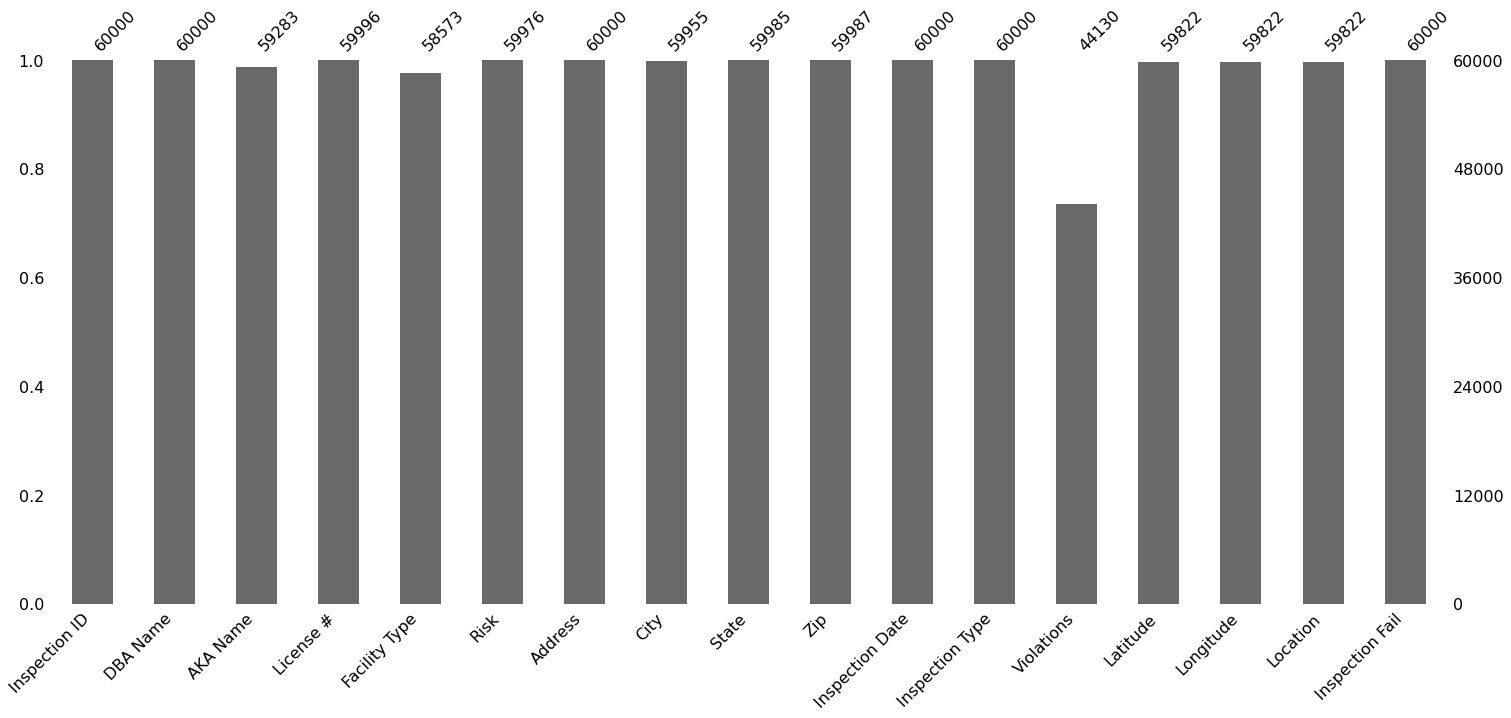

In [33]:
# 이 곳에 답안을 작성해주시길 바랍니다
import missingno as msno
msno.bar(train)

# Part 2: 모델링 (Modeling)

## 2.1 검증 방식 (Cross-validation / Hold-out validation)을 정한 후 데이터셋을 목적에 맞게 분할하세요

## **수정 부분 : 피드백 주신 대로 hold-out validation으로 데이터셋 나누었습니다.**

In [34]:
# 이 곳에 답안을 작성해주시길 바랍니다
# Hold-out validation
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, train_size=0.8, random_state=0)

train.head()



,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
5778,1345450,MORTON'S STEAKHOUSE-WACKER PLACE,MORTON'S STEAKHOUSE,1491372.0,Restaurant,Risk 1 (High),65 E WACKER PL,CHICAGO,IL,60601.0,2013-08-14,Canvass,NaN,41.886704,-87.625496,"(-87.62549637410729, 41.886704230249315)",0
5287,2145638,DUBLIN BAR & GRILL,DUBLIN BAR & GRILL,26748.0,Restaurant,Risk 1 (High),1050 N STATE ST,CHICAGO,IL,60610.0,2018-02-27,Complaint,29. PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42...,41.901867,-87.628492,"(-87.62849214526828, 41.901867356818784)",1
57167,1307539,A & J FOOD MARKET INCORPORATED,A & J FOOD MARKET INCORPORATED,69143.0,Grocery Store,Risk 1 (High),342 W 75TH ST,CHICAGO,IL,60621.0,2014-07-16,Canvass,19. OUTSIDE GARBAGE WASTE GREASE AND STORAGE A...,41.758200,-87.633757,"(-87.63375706271778, 41.7581997027466)",1
29516,1465142,ISLA TROPICAL,ISLA TROPICAL,2211455.0,Mobile Frozen Desserts Vendor,Risk 3 (Low),2335 N CICERO AVE,CHICAGO,IL,60639.0,2015-09-21,License,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.923491,-87.746132,"(-87.74613233682382, 41.92349095750785)",0
58610,1389353,CITGO FUEL & MINI MART,CITGO,2177986.0,Grocery Store,Risk 3 (Low),304-310 S CICERO AVE,CHICAGO,IL,60644.0,2014-02-21,Complaint,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.876622,-87.745287,"(-87.74528678507123, 41.87662240466685)",0


In [35]:
val.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Inspection Fail
3048,1184323,DUNKIN DONUTS / BASKIN ROBINS,DUNKIN DONUTS / BASKIN ROBINS,1742999.0,Restaurant,Risk 2 (Medium),555 W LAKE ST,CHICAGO,IL,60661.0,2012-05-17,Canvass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.885592,-87.642000,"(-87.6420002935186, 41.88559227197418)",0
19563,2151049,MAKOTO,MAKOTO,1470908.0,Restaurant,Risk 1 (High),5854-5856 N LINCOLN AVE,CHICAGO,IL,60659.0,2018-03-27,Canvass,"16. FOOD PROTECTED DURING STORAGE, PREPARATION...",41.987792,-87.703251,"(-87.70325097030259, 41.98779176423725)",1
58303,1369226,HAMPTON INN AND HOMEWOOD SUITES CHICAGODOWNTOW...,HAMPTON INN AND HOMEWOOD SUITES,1817133.0,Restaurant,Risk 1 (High),150-160 E HURON ST,CHICAGO,IL,60611.0,2013-09-25,Canvass Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.895061,-87.623508,"(-87.62350750911575, 41.895060785681196)",0
8870,2082173,PASTEUR OF CHICAGO,PASTEUR,2068942.0,Restaurant,Risk 1 (High),5523-5525 N BROADWAY,CHICAGO,IL,60640.0,2017-09-14,Canvass,29. PREVIOUS MINOR VIOLATION(S) CORRECTED 7-42...,41.982514,-87.659890,"(-87.6598903528276, 41.982514139614246)",1
40228,1464726,CERMAK PRODUCE #3,CERMAK PRODUCE #3,2292944.0,Grocery Store,Risk 1 (High),4800 W DIVERSEY AVE,CHICAGO,IL,60639.0,2015-01-29,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.931641,-87.746720,"(-87.7467199106462, 41.93164142040689)",0


## 2.2 모델 학습을 위한 파이프라인을 구축 후 학습(fit)까지 진행하세요
> 모델은 scikit-learn, xgboost 등 어떤 라이브러리를 사용하셔도 괜찮지만 특정 라이브러리는 설치 및 설정에 시간이 소요되는 점을 감안하시기 바랍니다

In [36]:
# 이 곳에 답안을 작성해주시길 바랍니다
from sklearn.model_selection import train_test_split, cross_val_score
from category_encoders import OneHotEncoder, TargetEncoder, OrdinalEncoder
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report


from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [37]:
X_train = train[features]
y_train = train[target]

In [38]:
X_train.shape, y_train.shape

((48000, 5), (48000, 1))

In [39]:
pipe = make_pipeline(
    
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(),

)

k = 3

scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='accuracy')

print(scores)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


[0.729375  0.7930625 0.794875 ]


In [40]:
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

In [41]:
pipe.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Facility Type', 'Risk',
                                      'Inspection Date', 'Inspection Type',
                                      'Violations'],
                                mapping=[{'col': 'Facility Type',
                                          'data_type': dtype('O'),
                                          'mapping': Restaurant                                          1
Grocery Store                                       2
Mobile Frozen Desserts Vendor                       3
Bakery                                              4
School                                              5
                                                 ... 
HERBAL REMEDY                                     328
RESTAURANT/LIQUOR                                 329
Shuffleboard Club with Bar                        330
MOBILE FROZEN DESSERTS DISPENSER-NO...
3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLED

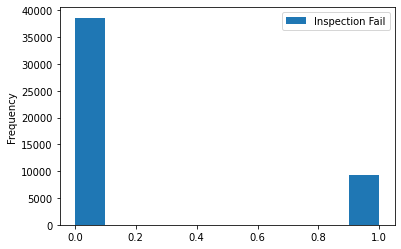

In [42]:
y_train.plot.hist()

In [43]:
y_pred = pipe.predict(X_val)

score = classification_report(y_val, y_pred)

In [44]:
print(score)

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      9633
           1       0.35      0.07      0.12      2367

    accuracy                           0.79     12000
   macro avg       0.58      0.52      0.50     12000
weighted avg       0.72      0.79      0.73     12000



## 2.3 테스트셋의 ROC / AUC 검증 점수를 예측합니다
> 제작한 모델을 활용해서 테스트셋의 **확률**을 예측하세요 (`ROC/AUC 검증 점수`를 **0.65 혹은 그 이상** 달성한다면 매우 훌륭한 모델입니다)

In [46]:
# 이 곳에 답안을 작성해주시길 바랍니다
from sklearn.metrics import roc_curve

y_pred_proba = pipe.predict_proba(X_val)

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba[:,1])

roc = pd.DataFrame({
    'FPR' : fpr,
    'TPR' : tpr,
    'Threshold' : thresholds

})
roc

,FPR,TPR,Threshold
0,0.000000,0.000000,1.980000
1,0.000104,0.000422,0.980000
2,0.000104,0.001267,0.960000
3,0.000727,0.001690,0.950000
4,0.000830,0.001690,0.945167
...,...,...,...
323,0.278522,0.405577,0.004583
324,0.278937,0.405577,0.004000
325,0.279871,0.405577,0.003333
326,0.279975,0.405577,0.002500


(0.0, 0.1)

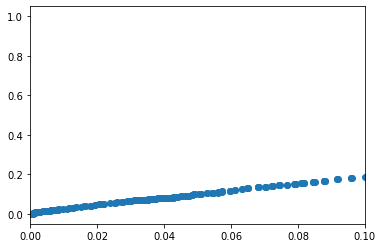

In [47]:
import matplotlib.pyplot as plt

plt.scatter(fpr, tpr)
plt.xlim(0,0.1)

In [48]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba[:,1])
auc_score

0.5712693669236826

## 2.4 하이퍼 파라미터 튜닝을 통해서 모델을 개선하세요
> `RandomSearchCV`, `GridSearchCV` 등을 활용해서 모델의 성능을 개선합니다. 범위 설정에 따라 시간이 매우 소요될 수 있습니다.

In [ ]:
XGBClassifier()

In [ ]:
# 이 곳에 답안을 작성해주시길 바랍니다
from sklearn.model_selection import RandomizedSearchCV

pipe = make_pipeline(

    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(),

)

# hyperparameter tuning
dists= {'simpleimputer__strategy': [ 'mean', 'median'],
        'xgbclassifier__n_estimators': [10,20,50,100],
        'xgbclassifier__max_depth': [3,5,7,10],
        'xgbclassifier__learning_rate': [0.01, 0.1, 0.2, 0.5]
}

clf = RandomizedSearchCV(
    pipe,
    param_distributions=dists,
    n_iter=20,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)


clf.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.3min finished
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [ ]:
clf.best_params_

{'simpleimputer__strategy': 'mean',
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__n_estimators': 50}

In [ ]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,5,14,3,16,17,6,15,10,1,18,19,9,8,0,4,2,12,11,7,13
mean_fit_time,1.62057,1.65471,3.91834,2.79053,1.17953,4.33243,0.854247,1.56658,0.90652,0.990891,0.879546,2.0841,1.26607,1.20662,4.69892,4.72538,1.54316,1.52594,4.12049,1.60779
std_fit_time,0.00211038,0.0268712,0.03977,0.019788,0.00415897,0.0745451,0.0237758,0.062766,0.00968017,0.0290184,0.162313,0.0561116,0.00544863,0.0206153,0.100841,0.0922266,0.0379488,0.0564155,0.0327986,0.0313913
mean_score_time,0.0912102,0.110864,0.168851,0.105611,0.0778282,0.124349,0.0723648,0.0921117,0.0870759,0.0700131,0.0637476,0.0894653,0.0819852,0.0929027,0.109924,0.111428,0.0949445,0.0842934,0.14971,0.111438
std_score_time,0.00343472,0.015002,0.0234611,0.00230841,0.00132461,0.00448548,0.00193494,0.0105447,0.0163748,0.00181802,0.0114388,0.00447434,0.00705407,0.0210488,0.0119139,0.0189255,0.0163391,0.00843594,0.00721097,0.0302359
param_xgbclassifier__n_estimators,50,50,50,100,20,100,10,20,10,10,10,20,10,10,50,50,20,20,50,50
param_xgbclassifier__max_depth,3,3,10,3,5,5,5,7,7,7,7,10,10,10,10,10,7,7,10,3
param_xgbclassifier__learning_rate,0.1,0.1,0.5,0.01,0.1,0.01,0.5,0.1,0.1,0.1,0.2,0.1,0.2,0.2,0.01,0.01,0.01,0.01,0.2,0.5
param_simpleimputer__strategy,mean,median,median,median,median,mean,median,median,mean,median,median,mean,median,mean,mean,median,median,mean,mean,mean
params,"{'xgbclassifier__n_estimators': 50, 'xgbclassi...","{'xgbclassifier__n_estimators': 50, 'xgbclassi...","{'xgbclassifier__n_estimators': 50, 'xgbclassi...","{'xgbclassifier__n_estimators': 100, 'xgbclass...","{'xgbclassifier__n_estimators': 20, 'xgbclassi...","{'xgbclassifier__n_estimators': 100, 'xgbclass...","{'xgbclassifier__n_estimators': 10, 'xgbclassi...","{'xgbclassifier__n_estimators': 20, 'xgbclassi...","{'xgbclassifier__n_estimators': 10, 'xgbclassi...","{'xgbclassifier__n_estimators': 10, 'xgbclassi...","{'xgbclassifier__n_estimators': 10, 'xgbclassi...","{'xgbclassifier__n_estimators': 20, 'xgbclassi...","{'xgbclassifier__n_estimators': 10, 'xgbclassi...","{'xgbclassifier__n_estimators': 10, 'xgbclassi...","{'xgbclassifier__n_estimators': 50, 'xgbclassi...","{'xgbclassifier__n_estimators': 50, 'xgbclassi...","{'xgbclassifier__n_estimators': 20, 'xgbclassi...","{'xgbclassifier__n_estimators': 20, 'xgbclassi...","{'xgbclassifier__n_estimators': 50, 'xgbclassi...","{'xgbclassifier__n_estimators': 50, 'xgbclassi..."
split0_test_score,0.56745,0.56745,0.52995,0.51615,0.51615,0.51625,0.516,0.51615,0.51615,0.51615,0.5161,0.5157,0.51545,0.51545,0.51515,0.51515,0.51515,0.51515,0.51485,0.5082


In [ ]:
clf.best_score_

0.7255833333333334

In [ ]:
# 가장 성능이 좋은 모델 선정. Test
pipe = clf.best_estimator_

X_test = test[features]
y_test = test[target]

y_pred = pipe.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.805


In [ ]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      1.00      0.89     16102
           1       0.00      0.00      0.00      3898

    accuracy                           0.81     20000
   macro avg       0.40      0.50      0.45     20000
weighted avg       0.65      0.81      0.72     20000



## Part 3: 시각화 (Visualization)

> 모델의 해석을 위한 시각화를 해주세요. 아래의 제시 된 종류 중 2가지를 선택하세요 (시각화에 가장 중요한 것은 **여러분의 분석**입니다.):
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [ ]:
# 이 곳에 답안을 작성해주시길 바랍니다



